In [16]:
%pip install catboost scikit-optimize ydata-profiling scikit-learn pandas numpy matplotlib yellowbrick


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
# IMPORTANDO BIBLIOTECAS

# MANEJAR DADOS
import pandas as pd
import numpy as np

# 2. PLOTAR DADOS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
from matplotlib.colors import ListedColormap


# 3. PREPROCESSAMENTO DOS DADOS
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from ydata_profiling import ProfileReport
# 4. Iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 5. Bibliotecas para separamento de cojuntos de dados
from sklearn.model_selection import train_test_split,cross_val_predict,GridSearchCV, cross_val_score,KFold,StratifiedKFold
from imblearn.over_sampling import SMOTE

# 6. Algoritmos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,RandomForestRegressor
from xgboost import XGBClassifier

import pickle

# 7. Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score,ConfusionMatrixDisplay , mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, roc_curve, auc


from concurrent.futures import ThreadPoolExecutor  # Biblioteca para programação em multi-thread, para diminuir tempo de execução das métricas

# 8. Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# EDA

In [18]:
df = pd.read_csv("./Heart_disease_cleveland_new.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [20]:
X= df.drop(['target'], axis=1)
y = df['target']

In [35]:
y

0      0
1      1
2      1
3      0
4      0
      ..
298    1
299    1
300    1
301    1
302    0
Name: target, Length: 303, dtype: int64

In [21]:
categorical_columns = ['thal', 'ca', 'slope', 'exang', 'restecg', 'cp', 'sex']

In [22]:
X_encoded = X.copy()
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X_encoded[col] = label_encoders[col].fit_transform(X[col])



In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

#importing pipeline
from sklearn.pipeline import Pipeline

In [24]:
from sklearn.preprocessing import MinMaxScaler  # 303
X_train, X_test, y_train, y_test  = train_test_split(X_encoded, y, test_size=0.1, random_state=42)
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)



In [25]:

def plot_confusion_matrix(model,cv):
    y_pred = cross_val_predict(model, X_encoded, y, cv=cv)
    cm = confusion_matrix(y, y_pred)

    # Extrair os valores TP, TN, FP, FN da matriz de confusão
    TN, FP, FN, TP = cm.ravel()

    # Calcular a acurácia
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def kfold_evaluate(model, k):
    resultados = {
        "Acurácia": None,
        "Precisão": None,
        "F1-score": None,
        "Recall": None
    }


    def plot_results():
        # Criando o gráfico de barras
        fig, ax = plt.subplots()
        barras = ax.bar(resultados.keys(), resultados.values(), color=['blue', 'green', 'orange', 'red'])

        # Adicionando os valores acima das barras
        for barra in barras:
            altura = barra.get_height()
            ax.annotate(f'{round(altura*100)}%', xy=(barra.get_x() + barra.get_width() / 2, altura),
                        xytext=(0, 3),  # 3 pixels de deslocamento vertical
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Adicionando título e rótulos aos eixos
        ax.set_ylabel('Porcentagem')
        ax.set_title('Resultados da validação cruzada')
        plt.ylim(0, max(resultados.values()) * 1.2)  # Limitando o eixo y
        plt.xticks(rotation=45)  # Rotacionando os rótulos do eixo x para facilitar a leitura

        # Exibindo o gráfico
        plt.tight_layout()
        plt.show()

    # Calculando as métricas
    resultados["Precisão"] = np.mean(cross_val_score(model, X_smote, y_smote, cv=k, scoring='precision'))
    resultados["Acurácia"] = np.mean(balanced_accuracy_score(model, X_smote, y_smote, cv=k, scoring='accuracy'))
    resultados["Recall"] = np.mean(cross_val_score(model, X_smote, y_smote, cv=k, scoring='recall'))
    resultados["F1-score"] = np.mean(cross_val_score(model, X_smote, y_smote, cv=k, scoring='f1'))

    # Plotando os resultados
    plot_results()


In [36]:
def train_test_evaluate(model, params, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded.values, y, test_size=test_size, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    X_train, y_train = X_train_resampled, y_train_resampled
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Avaliar as métricas
    accuracy = (accuracy_score(y_test, y_pred))
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    labels = ['Acurácia', 'Precisão', 'F1-Score', 'Recall']
    valores = [accuracy, precision,f1, recall]
    x = np.arange(len(labels))  # Localização dos rótulos no eixo x

    # Configurando o gráfico de barras
    plt.bar(x, valores, color=['blue', 'green', 'red', 'yellow'])
    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.xticks(x, labels)

    # Adicionando os valores exatos como labels nas barras
    for i in range(len(x)):
        plt.text(x[i], valores[i], f'{valores[i]:.0%}', ha='center', va='bottom')
    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.xticks(x, labels)
    plt.title('Acurácia e Precisão do Modelo')
    plt.show()
    # print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1}\n")


In [28]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_encoded, y,)

# Ensemble Learning

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

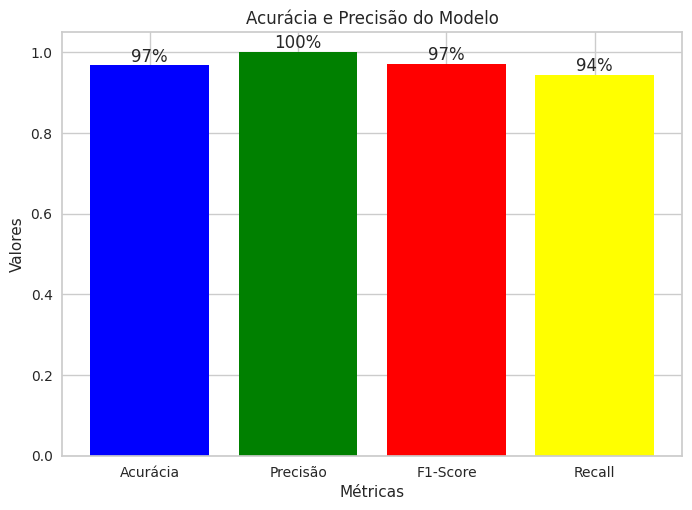

In [37]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import numpy as np

params_rf = {"criterion": "gini", "max_depth": 8, "max_features": "auto", "n_estimators": 200}
params_rf = {}
params_catboost = {'n_estimators': 300, 'learning_rate': 0.001, 'random_state': 42, 'verbose': 0, 'depth': 4, 'loss_function': 'Logloss', 'class_weights': [1, 1.15]}
params_ab = {'n_estimators': 250,  'learning_rate': 0.6, 'random_state':42}
params_nb = {'var_smoothing': 1e-09}
params_xgb={'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'n_estimator': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'eval_metric': 'logloss', 'colsample_bytree': 0.6}
# params_xgb = {'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.8}
logistic_rg_params = {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 10}
params_gb = {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.2}

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Random Forest, CatBoost, XGBoost, Nayes BAyes, AdaBoost, Logistic Regression, Gradient Boost
rf_model = RandomForestClassifier(**params_rf)
catboost_model = CatBoostClassifier(**params_catboost)
xgb_model = XGBClassifier(**params_xgb)
nb_model = GaussianNB(**params_nb)
ab_model = AdaBoostClassifier(**params_ab)
lg_model = LogisticRegression(**logistic_rg_params)
gb_model = GradientBoostingClassifier(**params_gb)

# ensemble_weights =  [1, 2, 1, 1, 2, 1]
# ensemble_weights = [1, 4, 1, 1, 2, 1]
ensemble_weights = [1, 7, 1, 1, 2, 1]
TEST_SIZE = 0.1
ensemble = VotingClassifier(estimators=[
    ('lg', lg_model),
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('catboost', catboost_model),
    ('ab', ab_model),
    ('nb', nb_model)
    ], voting='hard', weights=ensemble_weights)
# kfold_evaluate(ensemble, kf)
train_test_evaluate(ensemble, {}, TEST_SIZE)
#    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=test_size, random_state=42)
#     smote = SMOTE(random_state=42)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
#     X_train, y_train = X_train_resampled, y_train_resampled
#     model.set_params(**params)
#     model.fit(X_train, y_train)


In [38]:

with open('trained_model-0.1.0.pkl', 'wb') as f:
    pickle.dump(ensemble, f)
